## Hyperparam Tuning

Now that we know which models are performing better, it's time to perform cross validation and tune hyperparameters.
- Do a google search for hyperparameter ranges for each type of model.

GridSearch/RandomSearch are a great methods for checking off both of these tasks.

There is a fairly significant issue with this approach for this particular problem (described below). But in the interest of creating a basic functional pipeline, you can just use the default Sklearn methods for now.

## Preventing Data Leakage in Tuning - STRETCH

> **This step doesn't need to be part of your Minimum Viable Product (MVP), but its highly recommended you complete it, if you have time!**

BUT we have a problem - if we calculated a numerical value to encode city (such as the mean of sale prices in that city) on the training data, we can't cross validate 
- The rows in each validation fold were part of the original calculation of the mean for that city - that means we're leaking information!
- While sklearn's built in functions are extremely useful, sometimes it is necessary to do things ourselves

You need to create two functions to replicate what Gridsearch does under the hood. This is a challenging, real world data problem! To help you out, we've created some psuedocode and docstrings to get you started. 

**`custom_cross_validation()`**
- Should take the training data, and divide it into multiple train/validation splits. 
- Look into `sklearn.model_selection.KFold` to accomplish this - the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) shows how to split a dataframe and loop through the indexes of your split data. 
- Within your function, you should compute the city means on the training folds just like you did in Notebook 1 - you may have to re-join the city column to do this - and then join these values to the validation fold

This psuedocode may help you fill in the function:

```python
kfold = KFold() # fit sklearn k folds on X_train
train_folds = []
val_folds = []
for training_index, val_index in kfold.split(X_train):
    train_fold, val_fold = #.iloc loop variables on X_train

    # recompute training city means like you did in notebook 1 
    # merge to validation fold
        
    train_folds.append(train_fold)
    val_folds.append(val_fold)

    return train_folds, val_folds
```


**`hyperparameter_search()`**
- Should take the validation and training splits from your previous function, along with your dictionary of hyperparameter values
- For each set of hyperparameter values, fit your chosen model on each set of training folds, and take the average of your chosen scoring metric. [itertools.product()](https://docs.python.org/3/library/itertools.html) will be helpful for looping through all combinations of hyperparameter values
- Your function should output the hyperparameter values corresponding the highest average score across all folds. Alternatively, it could also output a model object fit on the full training dataset with these parameters.


This psuedocode may help you fill in the function:

```python
hyperparams = # Generate hyperparam options with itertools
hyperparam-scores = []
for hyperparam-combo in hyperparams:

    scores = []

    for folds in allmyfolds:
        # score fold the fold with the model/ hyperparams
        scores.append(score-fold)
        
    score = scores.mean()
    hyperparam-scores.append(score)
# After loop, find max of hyperparam-scores. Best params are at same index in `hyperparams` loop iteratble
```

Docstrings have been provided below to get you started. Once you're done developing your functions, you should move them to `functions_variables.py` to keep your notebook clean 

Bear in mind that these instructions are just one way to tackle this problem - the inputs and output formats don't need to be exactly as specified here.

In [1]:
# develop your custom functions here

def custom_cross_validation(training_data, n_splits =5):
    '''creates n_splits sets of training and validation folds

    Args:
      training_data: the dataframe of features and target to be divided into folds
      n_splits: the number of sets of folds to be created

    Returns:
      A tuple of lists, where the first index is a list of the training folds, 
      and the second the corresponding validation fold

    Example:
        >>> output = custom_cross_validation(train_df, n_splits = 10)
        >>> output[0][0] # The first training fold
        >>> output[1][0] # The first validation fold
        >>> output[0][1] # The second training fold
        >>> output[1][1] # The second validation fold... etc.
    '''

    return training_folds, validation_folds

def hyperparameter_search(training_folds, validation_folds, param_grid):
    '''outputs the best combination of hyperparameter settings in the param grid, 
    given the training and validation folds

    Args:
      training_folds: the list of training fold dataframes
      validation_folds: the list of validation fold dataframes
      param_grid: the dictionary of possible hyperparameter values for the chosen model

    Returns:
      A list of the best hyperparameter settings based on the chosen metric

    Example:
        >>> param_grid = {
          'max_depth': [None, 10, 20, 30],
          'min_samples_split': [2, 5, 10],
          'min_samples_leaf': [1, 2, 4],
          'max_features': ['sqrt', 'log2']} # for random forest
        >>> hyperparameter_search(output[0], output[1], param_grid = param_grid) 
        # assuming 'ouput' is the output of custom_cross_validation()
        [20, 5, 2, 'log2'] # hyperparams in order
    '''

    return hyperparameters


## Hyperparam Tuning

In [2]:
import pandas as pd


X_train = pd.read_csv('../data/processed/X_train.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')
y_train = pd.read_csv('../data/processed/y_train.csv').squeeze() 
y_test = pd.read_csv('../data/processed/y_test.csv').squeeze()


In [3]:
# Impute missing values in X_train and X_test
from sklearn.impute import SimpleImputer


X_imputer = SimpleImputer(strategy='mean')
X_train_imputed = X_imputer.fit_transform(X_train)  # Fit on X_train and transform X_train
X_test_imputed = X_imputer.transform(X_test)  # Transform X_test using the same fit from X_train

# Impute missing values in y_train and y_test
y_imputer = SimpleImputer(strategy='mean')
y_train_imputed = y_imputer.fit_transform(y_train.values.reshape(-1, 1)).ravel()  # Fit on y_train and transform y_train
y_test_imputed = y_imputer.transform(y_test.values.reshape(-1, 1)).ravel()  # Transform y_test using the same fit from y_train


In [4]:
import itertools
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV

def custom_hyperparameter_search(model, param_grid, X, y, cv=5):
    best_score = float('inf')
    best_params = None
    
    for param_combination in itertools.product(*param_grid.values()):
        params = dict(zip(param_grid.keys(), param_combination))
        model.set_params(**params)
        
        # Custom Cross-validation
        scores = []
        kfold = KFold(n_splits=cv, shuffle=True, random_state=42)
        for train_idx, val_idx in kfold.split(X):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            scores.append(mean_absolute_error(y_val, y_pred))
        
        mean_score = sum(scores) / len(scores)
        
        # Check for the best score
        if mean_score < best_score:
            best_score = mean_score
            best_params = params
            
    return best_params, best_score

# Usage
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

model = RandomForestRegressor(random_state=42)
best_params, best_mae = custom_hyperparameter_search(model, param_grid, X_train_imputed, y_train_imputed)
print("Best Parameters:", best_params)
print("Best MAE:", best_mae)


Best Parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}
Best MAE: 0.06295615584093368


In [5]:
# RandomizedSearchCV
from sklearn.pipeline import Pipeline

# Define the pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('rf', RandomForestRegressor(random_state=42))
])

# Define the parameter grid
param_grid = {
    'rf__n_estimators': [100, 200, 500],
    'rf__max_depth': [10, 20, 30, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': [0.5, 'sqrt', 'log2'],
    'rf__bootstrap': [True, False]
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=50,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='neg_mean_absolute_error'
)

# Fit the model
random_search.fit(X_train_imputed, y_train_imputed)

# Best model evaluation
best_rf_model = random_search.best_estimator_
y_test_pred = best_rf_model.predict(X_test_imputed)
test_mae = mean_absolute_error(y_test_imputed, y_test_pred)
print(f"Test MAE: {test_mae:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Test MAE: 0.0484


                  Feature  Importance
1              sold_price    0.434428
3                lot_sqft    0.239602
4                    sqft    0.065856
5                   baths    0.062730
2              baths_full    0.057878
9          price_per_sqft    0.041086
8                    beds    0.039707
11              sold_year    0.033953
6                  garage    0.011532
0              year_built    0.004351
10           age_of_house    0.003784
7                 stories    0.001469
16            sqft_scaled    0.000733
15        lot_sqft_scaled    0.000643
17           baths_scaled    0.000550
13      sold_price_scaled    0.000444
20      list_price_scaled    0.000327
19            beds_scaled    0.000287
22    age_of_house_scaled    0.000195
21  price_per_sqft_scaled    0.000169
12      year_built_scaled    0.000154
14      baths_full_scaled    0.000068
18         stories_scaled    0.000052
Total Feature Importance Score: 1.0000


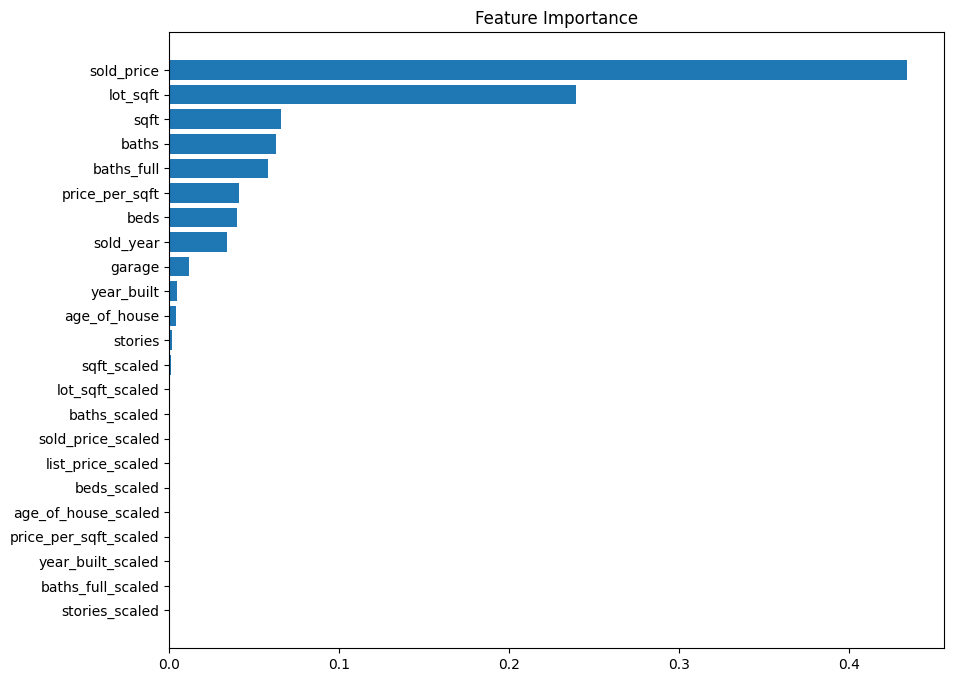

In [10]:
# Apply transformations and keep column names
from matplotlib import pyplot as plt


X_train_imputed_df = pd.DataFrame(X_train_imputed, columns=X_train.columns)

# Now, extract the feature importances
feature_importances = best_rf_model.named_steps['rf'].feature_importances_

# Ensure feature names match the transformed data
feature_names = X_train_imputed_df.columns if hasattr(X_train_imputed_df, 'columns') else [f'Feature {i}' for i in range(X_train_imputed_df.shape[1])]

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Print importance dataframe
print(importance_df)

# Calculate total feature importance score (sum of all importances)
total_importance_score = feature_importances.sum()
print(f"Total Feature Importance Score: {total_importance_score:.4f}")

# Visualization
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.title("Feature Importance")
plt.show()


We want to make sure that we save our models.  In the old days, one just simply pickled (serialized) the model.  Now, however, certain model types have their own save format.  If the model is from sklearn, it can be pickled, if it's xgboost, for example, the newest format to save it in is JSON, but it can also be pickled.  It's a good idea to stay with the most current methods. 
- you may want to create a new `models/` subdirectory in your repo to stay organized

In [7]:
import os
import joblib

# Define the path to save the model
models_folder = 'models'
os.makedirs(models_folder, exist_ok=True)

# Define the filename for the saved model
model_filename = os.path.join(models_folder, 'best_rf_model.pkl')

# Save the best model using joblib
joblib.dump(best_rf_model, model_filename)

print(f"Model saved to {model_filename}")


Model saved to models\best_rf_model.pkl


## Building a Pipeline (Stretch)

> **This step doesn't need to be part of your Minimum Viable Product (MVP), but its highly recommended you complete it if you have time!**

Once you've identified which model works the best, implement a prediction pipeline to make sure that you haven't leaked any data, and that the model could be easily deployed if desired.
- Your pipeline should load the data, process it, load your saved tuned model, and output a set of predictions
- Assume that the new data is in the same JSON format as your original data - you can use your original data to check that the pipeline works correctly
- Beware that a pipeline can only handle functions with fit and transform methods.
- Classes can be used to get around this, but now sklearn has a wrapper for user defined functions.
- You can develop your functions or classes in the notebook here, but once they are working, you should import them from `functions_variables.py` 

In [8]:
# Build pipeline here

Pipelines come from sklearn.  When a pipeline is pickled, all of the information in the pipeline is stored with it.  For example, if we were deploying a model, and we had fit a scaler on the training data, we would want the same, already fitted scaling object to transform the new data with.  This is all stored when the pipeline is pickled.
- save your final pipeline in your `models/` folder

In [9]:
# save your pipeline here